# Analyzing arrival time of flight

## Goal

Will be updated down the line ! Right now it is technical i.e. load data using Pandas, Use sci-kit to build model, and Use matplotlib to build visualizations !

## Load data

Download and load the data into a pandas data frame.

In [66]:
#!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

In [67]:
import pandas as pd

flightdata = pd.read_csv('flightdata.csv')
flightdata.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


## Perform data analysis

First inspect the dimensions of the data that is loaded.

In [68]:
flightdata.shape

(11231, 26)

Next extract the columns of the data, though we already have a glimpse by the `flightdata.head()` call. However, let us add the datatypes as well to be determined.

In [69]:
flightdata.columns
flightdata.dtypes

YEAR                     int64
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
UNIQUE_CARRIER          object
TAIL_NUM                object
FL_NUM                   int64
ORIGIN_AIRPORT_ID        int64
ORIGIN                  object
DEST_AIRPORT_ID          int64
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DEL15              float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DEL15              float64
CANCELLED              float64
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
DISTANCE               float64
Unnamed: 25            float64
dtype: object

Let us now inspect for any null values in the data. The check will let us know in boolean if there are nulls or not. Based on the result of the check, we will summarize per column how many null values are in the data. This will help us decide the corrective action required to make the dataset usefule. i.e. if the null values are in columns which we suspect will not have any colinearity to delay we could drop and for columns where we anticipate colinearity we should try to fill a reasonable value but if we fear of distorting the dataset we should remove the observation from the data itself.

In [70]:
if flightdata.isnull().values.any():
    print(flightdata.isnull().sum())
else:
    print('No null values!')

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64


Let us do the obvious thing first. That is remove the unintended parsing result away i.e. the column 25. We can do this by - 

In [71]:
flightdata = flightdata.drop('Unnamed: 25', axis=1)

Now let us check the impact on sum of nulls

In [72]:
flightdata.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

We are good here so, let us work on the relevancy of the columns and restructure our data frame a bit before we take another look on null columns.

E.g. columns like TAIL_NUM will have no bearing on the flight delay. Wehereas, the column like ARR_DEL15 will have more meaning in our analysis. Powered by such logic we will now reformat our data frame to have only the following columns - 

In [73]:
flightdata = flightdata[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CANCELLED', 'DIVERTED', 'ARR_DEL15']]
flightdata.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
CANCELLED         0
DIVERTED          0
ARR_DEL15       188
dtype: int64

It is evident that the column ARR_DEL15 is needed for the analysis of on-time or delay status of the field. We thus take a peek on some top data which are null for that column

In [74]:
flightdata[flightdata.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CANCELLED,DIVERTED,ARR_DEL15
177,1,9,6,MSP,SEA,701,0.0,1.0,NaN
179,1,10,7,MSP,DTW,1348,1.0,0.0,NaN
184,1,10,7,MSP,DTW,625,0.0,1.0,NaN
210,1,10,7,DTW,MSP,1200,1.0,0.0,NaN
478,1,22,5,SEA,JFK,2305,1.0,0.0,NaN


We notice that delayed flights which have NULL (NaN) in ARR_DEL15 are either cancelled or diverted flights. Following is the way to proove that!

In [75]:
allnas = flightdata[flightdata.isna().values.any(axis=1)]
cancelled = allnas[['CANCELLED']]
diverted = allnas[['DIVERTED']]
total_canc_div_flights = float(cancelled.sum()) + float(diverted.sum())


if(total_canc_div_flights == float(flightdata.isnull()['ARR_DEL15'].sum())):
    print('Flights are either cancelled or diverted always for NULL values in arrival delay')
else:
    print('There could be other reasons for data having NULL values for arrival delay')

Flights are either cancelled or diverted always for NULL values in arrival delay


Now that we are sure that the ARR_DEL15 is NULL because of delayed or cancelled flight. However, instead of dropping those rows we can fill them with 1's, i.e. they are considered as delayed as it would have caused the passengers if not same level of discomfort at least more discomfort.

In [76]:
flightdata = flightdata.fillna({'ARR_DEL15':1})
flightdata.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CANCELLED,DIVERTED,ARR_DEL15
177,1,9,6,MSP,SEA,701,0.0,1.0,1.0
178,1,9,6,DTW,JFK,1527,0.0,0.0,0.0
179,1,10,7,MSP,DTW,1348,1.0,0.0,1.0
180,1,10,7,DTW,MSP,1540,0.0,0.0,0.0
181,1,10,7,JFK,ATL,1325,0.0,0.0,0.0
182,1,10,7,JFK,ATL,610,0.0,0.0,0.0
183,1,10,7,JFK,SEA,1615,0.0,0.0,0.0
184,1,10,7,MSP,DTW,625,0.0,1.0,1.0


The CRS_DEP_TIME column of the dataset you are using represents scheduled departure times. The granularity of the numbers in this column — it contains more than 500 unique values — could have a negative impact on accuracy in a machine-learning model. This can be resolved using a technique called binning or quantization. What if you divided each number in this column by 100 and rounded down to the nearest integer? 1030 would become 10, 1925 would become 19, and so on, and you would be left with a maximum of 24 discrete values in this column. Intuitively, it makes sense, because it probably doesn't matter much whether a flight leaves at 10:30 a.m. or 10:40 a.m. It matters a great deal whether it leaves at 10:30 a.m. or 5:30 p.m.

In [77]:
import math

for index, row in flightdata.iterrows():
    flightdata.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
    
flightdata.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CANCELLED,DIVERTED,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0,0.0,0.0
1,1,1,5,DTW,MSP,13,0.0,0.0,0.0
2,1,1,5,ATL,SEA,9,0.0,0.0,0.0
3,1,1,5,SEA,MSP,8,0.0,0.0,0.0
4,1,1,5,SEA,DTW,23,0.0,0.0,0.0


Now we will be adding indicator columns for the ORIG and DEST ports

In [78]:
flightdata = pd.get_dummies(flightdata, columns=['ORIGIN','DEST'])
flightdata.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CANCELLED,DIVERTED,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0


We are more close to building a model now. To begin we will split data for the training and validation using the most familiar 80-20 split.

In [79]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(flightdata.drop(['ARR_DEL15', 'CANCELLED', 'DIVERTED'], axis=1), flightdata['ARR_DEL15'], test_size=0.2, random_state=42)

print('Shape of the training features')
print(train_x.shape)

print('Shape of the test features')
print(test_x.shape)

print('Shape of the training labels')
print(train_y.shape)

print('Shape of the testing labels')
print(test_y.shape)

Shape of the training features
(8984, 14)
Shape of the test features
(2247, 14)
Shape of the training labels
(8984,)
Shape of the testing labels
(2247,)


Let us take a moment and understand what we are attempting to accomplish here. We intend to determine based on the parameters will the flight be delayed on arriving? Thus, we intend to classify the records in the dataset as delayed for arrival or not delayed for arrival.
It is very different from regression. Regression is more of extrapolating the known numerical values and extending it to situations where no observations has been made.

Thus, we need to use a classification model. Particularly binary classification model; since we have two classes that needs to be determined. To get started, there is no yardstick for Data Scientist to use select a specific algorithm. Only way is to build a model using the algorithm and determine the performance of the algorithm before deciding to move on to change the algorithm itself.

We start with RandomForestClassifier which happens to be a robost classification mechanism

In [80]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [81]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8602581219403649

Having a model is not sufficient. We need to score the model which is a great starting point for evaluating the model accuracy. Higher the score better the model is the common notion. Score will range from 0 - 1. Score alone is not a solid enough metric to move ahead with. There are other better measures which will be expand into here for the built model.
We will use the Receiver Operating Curve (ROC) measure which plots true positive and false positive and the area under that curve is used to compute the accuracy of the model. In plain English the area determines how often will the model make correct predictions which is based on the probabilities i.e. regardless of the actual outcome.

In [82]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)
roc_auc_score(test_y, probabilities[:,1])

0.6743824904998539

This is a true indicator of performance without any observation bias. This is a low score. We can dive further to determine the cause for low area under ROC curve. We do that using the metric confusion matrix or error matrix. This matrix tells us how many times did both class of prediction go down i.e. the class of delay in arrival as well on-time arrival. Model which predicts only one class well with higher than 90% of records is of no use as it misses to see and take notice of the other class at all.

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1882,   54],
       [ 260,   51]])

This matrix is reads as
    
    [True Positive,   False Negative
     False Positive,  True Negative]

One of the other measure used for the classification model is the precision and recall score which could be used.

In [84]:
from sklearn.metrics import precision_score
train_prediction_precision = model.predict(train_x)
precision_score(train_y, train_prediction_precision)

0.9972375690607734

This seems to be rather great score for percision. Percision is the models ability to predict accurately the correct outcome when we already knew the actual outcome (thus, we used the train_y here instead of test_y) i.e. from the training data set. If we try to do this on test data we are bound to reflect the other metrics statements - 

In [85]:
from sklearn.metrics import precision_score
test_prediction = model.predict(test_x)
precision_score(test_y, test_prediction)

0.4857142857142857

We can now move on to the recall metrics which represents the model's ability to determine the correct outcome on the given dataset

In [86]:
from sklearn.metrics import recall_score
train_prediction_recall = model.predict(train_x)
recall_score(train_y, train_prediction_recall)

0.8650159744408946

Let us add some visuals to the metrics and make it interesting

Text(0, 0.5, 'True positive rate')

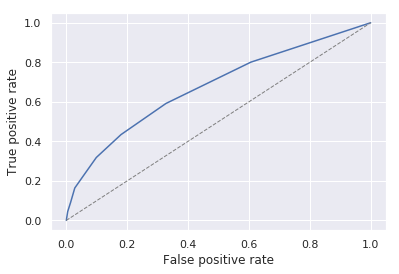

In [87]:
%matplotlib inline
import matplotlib.pyplot as mpl
import seaborn as sns

sns.set()

from sklearn.metrics import roc_curve

fp, tp, _ = roc_curve(test_y, probabilities[:,1])
mpl.plot(fp, tp)
mpl.plot([0,1],[0,1], color='grey', lw=1, linestyle='--')
mpl.xlabel('False positive rate')
mpl.ylabel('True positive rate')

We had all that we had so far done to be able to put it to use in a app (could be mobile or web or desktop). This will require wrapping up the model with a function a function which we could call from anywhere.

In [90]:
def predict_delay_probabilities(departure_datetime, origin_airport_code, destination_airport_code):
    from datetime import datetime
    
    try:
        dep_typed_datetime = datetime.strptime(departure_datetime, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date and time - {}'.format(e)
    
    month = dep_typed_datetime.month
    day = dep_typed_datetime.day
    day_of_week = dep_typed_datetime.isoweekday()
    hour = dep_typed_datetime.hour
    
    origin = origin_airport_code.upper()
    destination = destination_airport_code.upper()
    
    input_for_model = [{
        'MONTH': month,
        'DAY': day,
        'DAY_OF_WEEK': day_of_week,
        'CRS_DEP_TIME': hour,
        'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
        'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
        'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
        'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
        'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
        'DEST_ATL': 1 if destination == 'ATL' else 0,
        'DEST_DTW': 1 if destination == 'DTW' else 0,
        'DEST_JFK': 1 if destination == 'JFK' else 0,
        'DEST_MSP': 1 if destination == 'MSP' else 0,
        'DEST_SEA': 1 if destination == 'SEA' else 0,
    }]
    
    return model.predict_proba(pd.DataFrame(input_for_model))[0][0]

In [93]:
predict_delay_probabilities('1/10/2018 21:45:00', 'JFK', 'ATL')

0.6

Let us run this model for some more data and visualize the result

(0.0, 1.0)

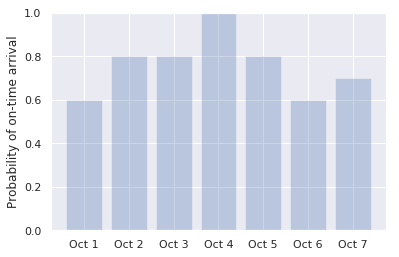

In [94]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay_probabilities('1/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('2/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('3/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('4/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('5/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('6/10/2018 21:45:00', 'JFK', 'ATL'),
         predict_delay_probabilities('7/10/2018 21:45:00', 'JFK', 'ATL'))

arranged_labels = np.arange(len(labels))
mpl.bar(arranged_labels, values, align='center', alpha=0.3)
mpl.xticks(arranged_labels, labels)
mpl.ylabel('Probability of on-time arrival')
mpl.ylim((0.0,1.0))